In [72]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

import matplotlib.pyplot as plt
import joblib
import seaborn as sns

# For predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

print("Library imported")

Library imported


In [73]:
# Load dataset Symptomp severity
df_severity = pd.read_csv("dataset/Symptom-severity.csv")

# Load dataset Symptomp precaution
df_precaution = pd.read_csv("dataset/symptom_precaution.csv")

# Load dataset Symptomp description
df_description = pd.read_csv("dataset/symptom_Description.csv")

# Load dataset
df_dataset = pd.read_csv("dataset/dataset.csv")

print("Dataset loaded")

Dataset loaded


In [74]:
print("\n First 5 rows severity data")
print(df_severity.head())

print("\n First 5 rows precaution data")
print(df_precaution.head())

print("\n First 5 rows description data")
print(df_description.head())

print("\n First 5 rows dataset data")
print(df_dataset.head())


 First 5 rows severity data
                Symptom  weight
0               itching       1
1             skin_rash       3
2  nodal_skin_eruptions       4
3   continuous_sneezing       4
4             shivering       5

 First 5 rows precaution data
          Disease                      Precaution_1  \
0   Drug Reaction                   stop irritation   
1         Malaria          Consult nearest hospital   
2         Allergy                    apply calamine   
3  Hypothyroidism                     reduce stress   
4       Psoriasis  wash hands with warm soapy water   

                   Precaution_2        Precaution_3  \
0      consult nearest hospital    stop taking drug   
1               avoid oily food  avoid non veg food   
2       cover area with bandage                 NaN   
3                      exercise         eat healthy   
4  stop bleeding using pressure      consult doctor   

                  Precaution_4  
0                    follow up  
1           keep mos

In [75]:
print('Missing values in Symptom Severity Data:')
print(df_severity.isna().sum())

print('\nMissing values in Symptom Description Data:')
print(df_description.isna().sum())

print('\nMissing values in Symptom Precaution Data:')
print(df_precaution.isna().sum())

print('\nMissing values in Main Disease-Symptom Dataset:')
print(df_dataset.isna().sum())

Missing values in Symptom Severity Data:
Symptom    0
weight     0
dtype: int64

Missing values in Symptom Description Data:
Disease        0
Description    0
dtype: int64

Missing values in Symptom Precaution Data:
Disease         0
Precaution_1    0
Precaution_2    0
Precaution_3    1
Precaution_4    1
dtype: int64

Missing values in Main Disease-Symptom Dataset:
Disease          0
Symptom_1        0
Symptom_2        0
Symptom_3        0
Symptom_4      348
Symptom_5     1206
Symptom_6     1986
Symptom_7     2652
Symptom_8     2976
Symptom_9     3228
Symptom_10    3408
Symptom_11    3726
Symptom_12    4176
Symptom_13    4416
Symptom_14    4614
Symptom_15    4680
Symptom_16    4728
Symptom_17    4848
dtype: int64


In [76]:
# Preprocessing dataset and data severity

# Severity data
df_severity["Symptom"] = df_severity["Symptom"].str.lower().str.strip()
df_severity_map = dict(zip(df_severity["Symptom"], df_severity["weight"]))

# Dataset
df_dataset.fillna("", inplace=True)

symptom_cols = [col for col in df_dataset.columns if col.startswith("Symptom")]

all_symptoms = pd.unique(df_dataset[symptom_cols].values.ravel())
unknown_symptoms = [s for s in all_symptoms if s not in df_severity_map]
print(unknown_symptoms)


for col in symptom_cols:
    df_dataset[col] = df_dataset[col].astype(str) \
                     .str.replace(r"\s+", "", regex=True) \
                     .str.lower().str.strip()
    df_dataset[col] = df_dataset[col].map(df_severity_map).fillna(0).astype(int)

X = df_dataset[symptom_cols]
y = df_dataset["Disease"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

[' skin_rash', ' nodal_skin_eruptions', ' dischromic _patches', '', ' continuous_sneezing', ' shivering', ' chills', ' watering_from_eyes', ' stomach_pain', ' acidity', ' ulcers_on_tongue', ' vomiting', ' cough', ' chest_pain', ' yellowish_skin', ' nausea', ' loss_of_appetite', ' abdominal_pain', ' yellowing_of_eyes', ' burning_micturition', ' spotting_ urination', ' passage_of_gases', ' internal_itching', ' indigestion', ' muscle_wasting', ' patches_in_throat', ' high_fever', ' extra_marital_contacts', ' fatigue', ' weight_loss', ' restlessness', ' lethargy', ' irregular_sugar_level', ' blurred_and_distorted_vision', ' obesity', ' excessive_hunger', ' increased_appetite', ' polyuria', ' sunken_eyes', ' dehydration', ' diarrhoea', ' breathlessness', ' family_history', ' mucoid_sputum', ' headache', ' dizziness', ' loss_of_balance', ' lack_of_concentration', ' stiff_neck', ' depression', ' irritability', ' visual_disturbances', ' back_pain', ' weakness_in_limbs', ' neck_pain', ' weaknes

In [77]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Save model + label encoder
joblib.dump(model, "output/model.pkl")
joblib.dump(le, "output/label_encoder.pkl")
joblib.dump(symptom_cols, "output/symptom_list.pkl")

['output/symptom_list.pkl']

In [78]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Prediction Accuracy:', accuracy)

print("\n")

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Prediction Accuracy: 0.9908536585365854


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        21
           4       0.92      1.00      0.96        35
           5       1.00      1.00      1.00        26
           6       1.00      1.00      1.00        21
           7       1.00      0.83      0.91        24
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        25
          10       1.00      1.00      1.00        33
          11       1.00      1.00      1.00        35
          12       1.00      1.00      1.00        28
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        25
          15       1.00      0.89      0.94        18
          16    

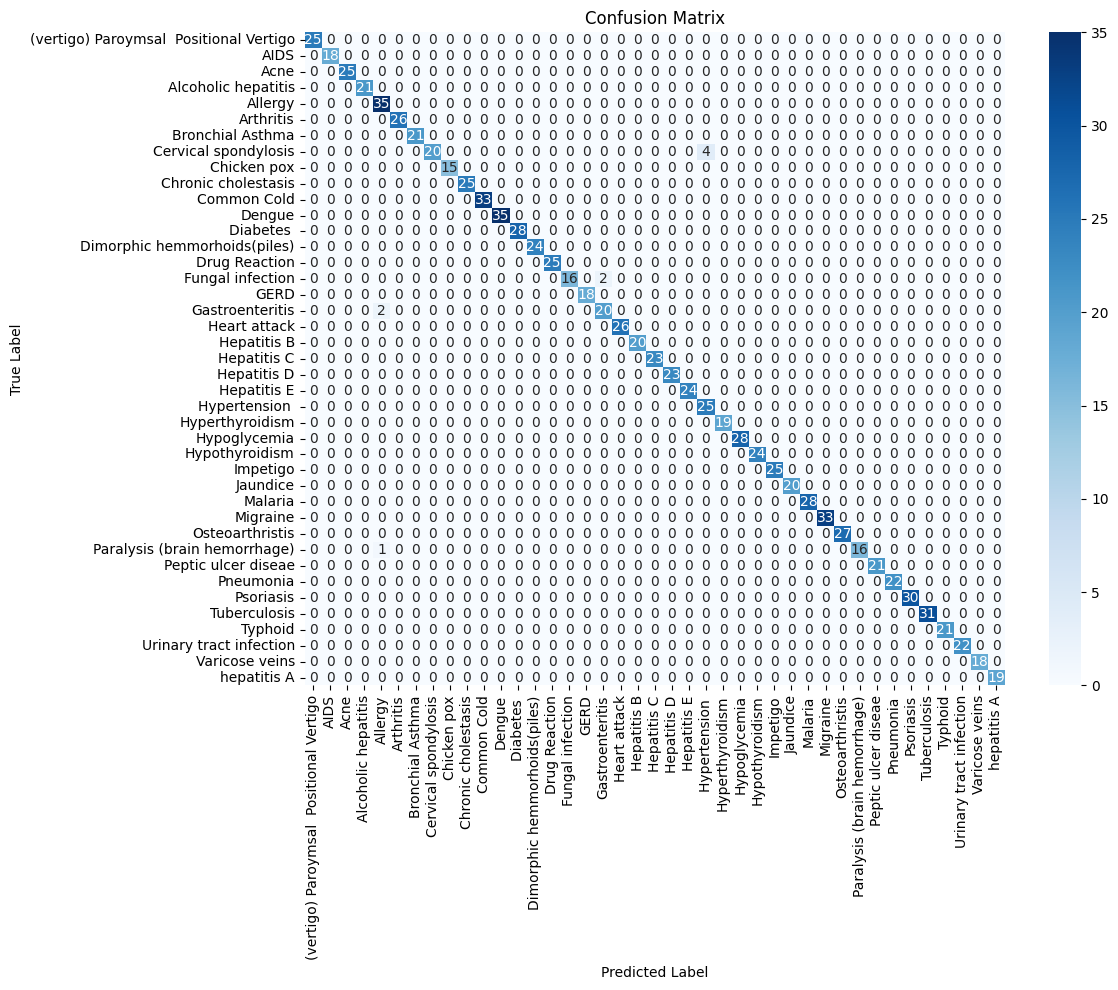

In [79]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = le.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()